# APS fly scans with taxi & fly `busy` records

Some EPICS fly scans at APS are triggered by a pair of EPICS
[*busy*](https://epics-modules.github.io/busy/) records.  The first *busy*
record is called `taxi` and is responsible for preparing the hardware to fly.
Once *taxi* is complete, the second *busy* record called `fly` performs the
actual fly scan. In a third (optional) phase, data is collected from hardware
and written to a file.  Each *busy* record initates a sequence of processing
steps as defined by other EPICS records.

This document shows how to operate such a scan with two examples.  We'll refer to *taxi* and *fly* as phases.

- simplified processing sequence for each phase
  - shows the basic flow of control
  - sequence: delay a short time, then return
  - no data collection
- step scan of scaler *v*. motor
  - includes data collection
  - plot saved data
  - typical use case for APS beamlines

## Overview

Compare the taxi & fly scan algorithm to an airplane flight:

phase | airplane flight | taxi & fly scan
--- | --- | ---
preparation | ticketing & boarding | configuration of software
taxi | move the aircraft to the start of the runway | move the hardware to pre-scan positions
fly | start moving, liftoff at flight velocity | start moving, begin collecting data at first position

## Bluesky (Python) setup

These packages are needed to begin.  The first block contains Python standard
packages, then come the various bluesky packages.  Just the parts we plan on
using here.

* Create a logger instance in case we want to investigate internal details as our code runs.
* Create an instance of the bluesky `RunEngine`.
* Create a temporary databroker catalog to save collected data.
* Subscribe the catalog to receive all data published by the RunEngine.

In [1]:
import logging
import time

from apstools.synApps import BusyRecord
from apstools.plans import run_blocking_function
import bluesky
import bluesky.plan_stubs as bps
import databroker
from ophyd import Component, Device, Signal
from ophyd.status import Status

logger = logging.getLogger()
logging.basicConfig(
    level=logging.INFO,  # more details than default (WARNING) level
    format="%(asctime)s %(levelname)s %(name)s - %(message)s"
)

RE = bluesky.RunEngine()
cat = databroker.temp().v2
RE.subscribe(cat.v1.insert)
# RE.msg_hook = bluesky.utils.ts_msg_hook  # deeper logging details
print(f"{cat=}")

cat=<Intake catalog: temp>


## EPICS IOC

We'll start with an EPICS IOC that provides two instances of the
[*busy*](https://epics-modules.github.io/busy/) record.

In the `gp:` IOC, we can use these general purpose PVs for this example:

PV | record | purpose
--- | --- | ---
`gp:mybusy1` | *busy* | taxi (preparation) phase
`gp:mybusy2` | *fly* | fly (fly scan) phase

Here, an ophyd `Device` subclass coordinates both of these PVs.  The `BusyRecord` class from [apstools.devices](https://bcda-aps.github.io/apstools/latest/api/synApps/index.html#records) provides a standard interface to the synApps `busy` record.

Handling of the `taxi` and `fly` phases is identical, as handled in the
`run_one_phase()` method.  A complete taxi/fly scan is performed by the
`taxi_fly_plan()` method.  Note that both these methods are bluesky plans. They
should be run by the bluesky RunEngine.  Also note that, as written, the
`taxi_fly_plan()` method does not collect any data.  As such, it should be
considered as a part of a bluesky
[plan](https://blueskyproject.io/bluesky/plans.html#plans) which [opens a
run](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.open_run.html#bluesky.plan_stubs.open_run)
and ([triggers
and](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.trigger_and_read.html#bluesky.plan_stubs.trigger_and_read))
[reads](https://blueskyproject.io/bluesky/generated/bluesky.plan_stubs.read.html)
data from one or more
[Signals](https://blueskyproject.io/ophyd/user/reference/signals.html) or
[Devices](https://blueskyproject.io/ophyd/user/tutorials/device.html).

In [2]:
def abs_put(signal, value):
    """Like bps.abs_set(), but without a Status object."""
    yield from run_blocking_function(signal.put, value)

class TaxiFlyScanDevice(Device):
    taxi = Component(BusyRecord, "mybusy1", kind="config")
    fly = Component(BusyRecord, "mybusy2", kind="config")
    taxi_timeout = Component(Signal, value=10, kind="config")
    fly_timeout = Component(Signal, value=10, kind="config")
    poll_interval = 0.02

    def run_one_phase(self, phase, busy):
        logger.info("%s phase start", phase)
        timeout=getattr(self, f"{phase}_timeout").get()

        yield from bps.sleep(self.poll_interval)
        yield from abs_put(busy.state, "Busy")
        # TODO: refactor with a status object
        #   Instead of polling, use Status to return to 'Done'.

        t0 = time.time()
        deadline = t0 + timeout
        while busy.state.get() not in (1, "Busy"):
            tNow = time.time()
            if tNow > deadline:
                raise TimeoutError(f"{phase} not started after {tNow-t0:.3f} s")
            yield from bps.sleep(self.poll_interval)
        logger.info("%s busy started", phase)

        t0 = time.time()
        deadline = t0 + timeout
        while busy.state.get() not in (0, "Done"):
            tNow = time.time()
            if tNow > deadline:
                raise TimeoutError(f"{phase} not complete after {tNow-t0:.3g} s")
            yield from bps.sleep(self.poll_interval)
        logger.info("%s busy cleared", phase)

        logger.info("%s phase end", phase)

    def taxi_fly_plan(self):
        yield from self.run_one_phase("taxi", self.taxi)
        yield from self.run_one_phase("fly", self.fly)

## The `busy` record

Summary: The *busy* record tells the *sseq* record to do all its processing
steps.  The *sseq* record waits its assigned time, then turns the *busy* record
off.

The *busy* record has a very limited task. It signals the procedure should start
and reports if the procedure is either `Busy` or `Done`. 

*The details of the procedure should be of no concern to the busy record.*

<details>

The EPICS *busy* record is quite simple.  It is a boolean that is used to
indicate if a procedure is still active (busy).  The caller is responsible for
setting it to `Busy` (value of 1) to start the procedure.  The procedure (and
**not** the caller) is responsible for setting it back to `Done` (value of 0)
when the procedure is finished.

![example of busy record](../_static/bf1-busy-record.png)

A *userCalc* (the *swait* record) starts the *sseq* record when the *busy* record changes to `Busy`.

</details>

## Procedure -- Delay a short time

A very simple procedure for the `taxi` phase might be to delay for a programmable time (seconds), then set `busy` to `Done`.  The `fly` phase could use the same procedure, with a different programmable time.

A *preparation* function is needed to configure the EPICS subsystem.  In addition to the `busy` record, each phase of this example will use these EPICS records.  The ophyd Device classes are from [apstools.synApps](https://bcda-aps.github.io/apstools/latest/api/synApps/index.html#records):

EPICS record | ophyd class | purpose
--- | --- | ---
sseq | SseqRecord | runs the procedure: delay for _n_ seconds, then set busy to `Done`
swait | SwaitRecord | Starts sseq when the busy record transitions to `Busy`.

Both phases use the same procedure steps.  A separate chain of busy/swait/sseq records is necessary for each phase.

Later, we'll demonstrate an EPICS step scan using the motor, scaler, and sscan
records.

### SseqRecord

The sseq record runs the procedure, then sets busy to `Done`.

<details>

![sseq record example](../_static/bf1-sseq-record.png)

Setting `.SCAN="Passive"` allows this record to process on command (from the
swait record, below).  Only the last step, step 10, is needed for this simple
_delay_ procedure.  Other procedures may use steps 1-9 for additional tasks.
For more than 10 steps, use an additional sseq record(s), called from a step in
this sseq record.

Write the delay time to `.DLYA`, the busy record value to write
(`.STRA="Done"`), and the busy record PV to be written (`LNKA`).  Note the use
of the `CA` modifier to the PV name, which is required for the `.WAITA="Wait"`
setting.

</details>

### SwaitRecord

The swait record acts like a trigger to start the sseq record.  It senses when busy changes value.

<details>

![swait record example](../_static/bf1-swait-record.png)

For both phases, the swait record watches its busy record (the PV name in channel A).  It reacts (via its `.SCAN="I/O Intr"` setting) when the busy record changes value.  When busy is 1 (via `.CALC="A>0"` and setting `.OOPT="When Non-zero"`), it tells sseq to process (by sending a 1 to the `.PROC` field of the sseq record configured in the `.OUTN` field).

</details>

### Connect with EPICS

Create local (ophyd-style) objects to connect with the EPICS IOC records.

(The `SscanRecord` will be used in a different procedure.)

In [3]:
from apstools.synApps import SseqRecord, SwaitRecord

IOC = "gp:"

ifly = TaxiFlyScanDevice(IOC, name="ifly")
taxi_sseq = SseqRecord(f"{IOC}userStringSeq1", name="taxi_sseq")
taxi_swait = SwaitRecord(f"{IOC}userCalc11", name="taxi_swait")
fly_sseq = SseqRecord(f"{IOC}userStringSeq2", name="fly_sseq")
fly_swait = SwaitRecord(f"{IOC}userCalc12", name="fly_swait")

for obj in (ifly, taxi_sseq, taxi_swait, fly_sseq, fly_swait):
    obj.wait_for_connection()

### Write the plan that prepares EPICS

The busy, swait, & sseq records for the taxi & fly phases are configured by the
following bluesky plan.

The plan uses predefined names for the ophyd objects, a pattern typical for
beamline plans.

#### The `reset()` method

The *SseqRecord* support in apstools has a `reset()` method to clear any
previous settings of the EPICS PVs and ophyd object and return them to default
settings.  Note: some of the other record support classes in *apstools.synApps*,
including *SwaitRecord* and *SscanRecord*, have such `reset()` methods.

The `reset()` method is written as ophyd code, intended to be called from a
command-line session.  The commands it contains that may take some time to
complete and possibly block the normal execution of the RunEngine's callback
thread. The
[run_blocking_function()](https://bcda-aps.github.io/apstools/latest/api/_plans.html#module-apstools.plans.run_blocking_function_plan)
plan from *apstools.plans* allows us to run `reset()` in a thread so that it
does not block the `RunEngine`.

In [4]:
def prep_taxi_fly_simple_delay(taxi_delay_s, fly_delay_s):
    """Delay before returning from both taxi & fly phases."""
    logger.debug("taxi time: %.2f s", taxi_delay_s)
    logger.debug("fly time: %.2f s", fly_delay_s)
    # stop any action in progress
    yield from bps.mv(
        ifly.fly.state, "Done",
        ifly.taxi.state, "Done",
    )
    # clear the taxi & fly busy records
    yield from bps.mv(
        ifly.fly.forward_link, "",
        ifly.fly.output_link, "",
        ifly.taxi.forward_link, "",
        ifly.taxi.output_link, "",
    )

    # clear the records to be used: swait and sseq
    for obj in (fly_sseq, fly_swait, taxi_sseq, taxi_swait):
        yield from run_blocking_function(obj.reset)
    yield from bps.sleep(0.2)  # arbitrary wait for EPICS record processing

    # busy record (via swait record) triggers sseq record
    yield from bps.mv(
        taxi_swait.scanning_rate, "I/O Intr",
        taxi_swait.channels.A.input_pv, ifly.taxi.prefix,
        taxi_swait.calculation, "A>0",
        taxi_swait.output_execute_option, "When Non-zero",
        taxi_swait.output_link_pv, taxi_sseq.process_record.pvname,
    )
    yield from bps.mv(
        fly_swait.scanning_rate, "I/O Intr",
        fly_swait.channels.A.input_pv, ifly.fly.prefix,
        fly_swait.calculation, "A>0",
        fly_swait.output_execute_option, "When Non-zero",
        fly_swait.output_link_pv, fly_sseq.process_record.pvname,
    )

    # taxi & fly will each wait the selected time, then return
    yield from bps.mv(
        taxi_sseq.steps.step10.string_value, "Done",
        taxi_sseq.steps.step10.wait_completion, "Wait",
        taxi_sseq.steps.step10.delay, taxi_delay_s,
        taxi_sseq.steps.step10.output_pv, f"{ifly.taxi.prefix} CA NMS",
    )
    yield from bps.mv(
        fly_sseq.steps.step10.string_value, "Done",
        fly_sseq.steps.step10.wait_completion, "Wait",
        fly_sseq.steps.step10.delay, fly_delay_s,
        fly_sseq.steps.step10.output_pv, f"{ifly.fly.prefix} CA NMS",
    )

### taxi -- Run the preparation plan

Call the `prep_taxi_fly_simple_delay()` plan (with the bluesky RunEngine, `RE`)
with delay times for each phase.

In [5]:
RE(prep_taxi_fly_simple_delay(2, 4))

2024-03-06 10:34:41,202 INFO bluesky - Executing plan <generator object prep_taxi_fly_simple_delay at 0x7fc0933f1000>
2024-03-06 10:34:41,204 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'idle' -> 'running'
2024-03-06 10:34:41,535 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'running' -> 'idle'
2024-03-06 10:34:41,536 INFO bluesky - Cleaned up from plan <generator object prep_taxi_fly_simple_delay at 0x7fc0933f1000>


()

### fly -- Run taxi & fly scan plan

Call the `taxi_fly_plan()` method with the bluesky RunEngine.  Note this plan completes in the ~6s interval, as configured in the preparation step.

In [6]:
ifly.fly_timeout.put(10)
RE(ifly.taxi_fly_plan())

2024-03-06 10:34:41,545 INFO bluesky - Executing plan <generator object TaxiFlyScanDevice.taxi_fly_plan at 0x7fc0767f6f60>
2024-03-06 10:34:41,546 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'idle' -> 'running'
2024-03-06 10:34:41,547 INFO root - taxi phase start
2024-03-06 10:34:41,569 INFO root - taxi busy started
2024-03-06 10:34:43,578 INFO root - taxi busy cleared
2024-03-06 10:34:43,579 INFO root - taxi phase end
2024-03-06 10:34:43,579 INFO root - fly phase start
2024-03-06 10:34:43,602 INFO root - fly busy started
2024-03-06 10:34:47,613 INFO root - fly busy cleared
2024-03-06 10:34:47,614 INFO root - fly phase end
2024-03-06 10:34:47,616 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'running' -> 'idle'
2024-03-06 10:34:47,617 INFO bluesky - Cleaned up from plan <generator object TaxiFlyScanDevice.taxi_fly_plan at 0x7fc0767f6f60>


()

## Procedure -- step scan scaler & motor

### scaler record
![scaler](../_static/bf1-scaler-record.png)

### motor record
![motor](../_static/bf1-motor-record.png)

In [7]:
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH

m1 = EpicsMotor(f"{IOC}m1", name="m1")
scaler1 = ScalerCH(f"{IOC}scaler1", name="scaler1")

for obj in (m1, scaler1):
    obj.wait_for_connection()

# convenience: pick out the individual detector signals from the scaler
I0 = scaler1.channels.chan02.s
scint = scaler1.channels.chan03.s
diode = scaler1.channels.chan04.s
I000 = scaler1.channels.chan05.s
I00 = scaler1.channels.chan06.s

### sscan record

![sscan scaler and motor](../_static/bf1-sscan-record.png)

In [8]:
from apstools.synApps import SscanRecord

scan1 = SscanRecord(f"{IOC}scan1", name="scan1")
scan1.wait_for_connection()

### Write a preparation plan for the step scan

The preparation plan configures these actions:

- preparation
  - setup 'sseq' records
    - for both *taxi* and *fly* phases
  - set counting time in *scaler* record
  - set scan parameters in *sscan* record
    - start, finish, number of points
    - motor PVs
    - detector PVs
    - detector trigger PVs
  - set *swait* records to start (process) *sseq* records
    - for both *taxi* and *fly* phases
    - only when *busy* record goes to `Busy`

- *taxi* phase
  - move the motor (EPICS) to the start of the *fly* scan
  - wait for the move to finish
  - set its *busy* record to `Done`

- *fly* phase 
  - execute the scan (process the (EPICS) *sscan* record)
  - wait for the scan to finish
  - set its *busy* record to `Done`

**Note**: The preparation plan does not actually move the motor or start the scan.
It configures the *sseq* records to do these actions when commanded by the
*busy* records.

The *busy* records start the *taxi* and *fly* phases.

In [9]:
def prep_taxi_fly_step_scan(start, finish, npts, ct):
    """Setup EPICS for step scan directed by taxi & fly."""
    logger.debug("start: %g s", start)
    logger.debug("finish: %g s", finish)
    logger.debug("number of points: %g s", npts)
    logger.debug("count time: %g s", ct)
    # stop any action in progress
    yield from bps.mv(
        ifly.fly.state, "Done",
        ifly.taxi.state, "Done",
    )
    # clear the taxi & fly busy records
    yield from bps.mv(
        ifly.fly.forward_link, "",
        ifly.fly.output_link, "",
        ifly.taxi.forward_link, "",
        ifly.taxi.output_link, "",
    )

    # clear the records to be used: swait, sscan, and sseq
    for obj in (fly_sseq, fly_swait, taxi_sseq, taxi_swait, scan1):
        yield from run_blocking_function(obj.reset)
    yield from bps.sleep(0.2)  # arbitrary wait for EPICS record processing

    yield from bps.mv(
        taxi_sseq.description, "taxi procedure",
        fly_sseq.description, "fly procedure",
    )

    # Move the motor to the start position.
    step = taxi_sseq.steps.step1
    yield from bps.mv(
        step.numeric_value, start,
        step.output_pv, f"{m1.prefix} CA NMS",
        step.wait_completion, "Wait",
    )

    # Start the sscan.
    step = fly_sseq.steps.step1
    yield from bps.mv(
        step.numeric_value, 1,
        step.output_pv, f"{scan1.execute_scan.pvname} CA NMS",
        step.wait_completion, "Wait",
    )

    # Configure scaler count time.
    yield from bps.mv(scaler1.preset_time, ct)

    # Configure sscan.
    yield from bps.mv(
        scan1.positioners.p1.readback_pv, m1.user_readback.pvname,
        scan1.positioners.p1.setpoint_pv, m1.user_setpoint.pvname,
        scan1.positioners.p1.start, start,
        scan1.positioners.p1.end, finish,
        scan1.number_points, npts,
        scan1.triggers.t1.trigger_pv, scaler1.count.pvname,
        scan1.detectors.d01.input_pv, I0.pvname,
        scan1.detectors.d02.input_pv, scint.pvname,
    )

    # Trigger taxi & fly sseq records (via swait record) from their busy records.
    yield from bps.mv(
        taxi_swait.scanning_rate, "I/O Intr",
        taxi_swait.channels.A.input_pv, ifly.taxi.prefix,
        taxi_swait.calculation, "A>0",
        taxi_swait.output_execute_option, "When Non-zero",
        taxi_swait.output_link_pv, taxi_sseq.process_record.pvname,
    )
    yield from bps.mv(
        fly_swait.scanning_rate, "I/O Intr",
        fly_swait.channels.A.input_pv, ifly.fly.prefix,
        fly_swait.calculation, "A>0",
        fly_swait.output_execute_option, "When Non-zero",
        fly_swait.output_link_pv, fly_sseq.process_record.pvname,
    )

    # taxi & fly: set busy record to `Done`
    step = taxi_sseq.steps.step10
    yield from bps.mv(
        step.string_value, "Done",
        step.output_pv, f"{ifly.taxi.prefix} CA NMS",
        step.wait_completion, "Wait",
    )
    step = fly_sseq.steps.step10
    yield from bps.mv(
        step.string_value, "Done",
        step.output_pv, f"{ifly.fly.prefix} CA NMS",
        step.wait_completion, "Wait",
    )

### taxi: prepare for scan

In [10]:
RE(prep_taxi_fly_step_scan(-1.1, 1.2, 11, 0.5))

2024-03-06 10:34:49,227 INFO bluesky - Executing plan <generator object prep_taxi_fly_step_scan at 0x7fc076f9f400>
2024-03-06 10:34:49,229 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'idle' -> 'running'
2024-03-06 10:34:49,671 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'running' -> 'idle'
2024-03-06 10:34:49,674 INFO bluesky - Cleaned up from plan <generator object prep_taxi_fly_step_scan at 0x7fc076f9f400>


()

### fly: run the scan

In [11]:
ifly.fly_timeout.put(60)  # might take longer than usual
RE(ifly.taxi_fly_plan())

2024-03-06 10:34:49,708 INFO bluesky - Executing plan <generator object TaxiFlyScanDevice.taxi_fly_plan at 0x7fc0767f4110>
2024-03-06 10:34:49,711 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'idle' -> 'running'
2024-03-06 10:34:49,713 INFO root - taxi phase start
2024-03-06 10:34:49,736 INFO root - taxi busy started
2024-03-06 10:34:52,331 INFO root - taxi busy cleared
2024-03-06 10:34:52,334 INFO root - taxi phase end
2024-03-06 10:34:52,337 INFO root - fly phase start
2024-03-06 10:34:52,366 INFO root - fly busy started
2024-03-06 10:35:04,447 INFO root - fly busy cleared
2024-03-06 10:35:04,447 INFO root - fly phase end
2024-03-06 10:35:04,448 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'running' -> 'idle'
2024-03-06 10:35:04,449 INFO bluesky - Cleaned up from plan <generator object TaxiFlyScanDevice.taxi_fly_plan at 0x7fc0767f4110>


()

### Need to save the data

Get the data (arrays) from `scan1` and make them into a readable ophyd device.

In [12]:
import numpy as np
from apstools.devices import make_dict_device

def get_taxi_fly_sscan_data():
    npts = scan1.current_point.get()
    xref = {
        m1.name: scan1.positioners.p1,
        I0.name: scan1.detectors.d01,
        scint.name: scan1.detectors.d02,
    }
    data = {
        name_: signal_.array.get()[:npts]
        for name_, signal_ in xref.items()
    }
    data["timestamps"] = np.zeros((npts))
    data = make_dict_device(data, name="scan1")
    return data

# r = get_taxi_fly_sscan_data().read()
# data = get_taxi_fly_sscan_data()

Write a bluesky plan that puts it all together:

- metadata
- bluesky run
- prepare EPICS for the taxi & fly scan
- taxi
- fly
- get the data
- publish data to primary stream

In [13]:
def taxi_fly_sscan_plan(start, finish, npts, ct, md={}):
    md["plan_name"] = "taxi_fly_sscan_plan"
    ifly.fly_timeout.put(60)  # might take longer than usual

    yield from bps.open_run(md)
    
    yield from prep_taxi_fly_step_scan(start, finish, npts, ct)

    timestamps = Signal(name="timestamps", value=[])  # collect by observing 'scan1'
    t0 = time.time()

    def callback(**kwargs):
        # print(f"{len(timestamps.get())=} {kwargs=}")
        if kwargs["value"] == 0:
            timestamps.put([])
        else:
            timestamps.put(timestamps.get() + [time.time() - t0])
            logger.info(f"callback: {kwargs['value']}  {time.time()-t0:.4f}  {m1.position=}")
    
    scan1.current_point.subscribe(callback)

    yield from ifly.taxi_fly_plan()
    t1 = time.time() - t0
    logger.info("Fly time: %.3f s", t1)
    scan1.current_point.clear_sub(callback)
    data = get_taxi_fly_sscan_data()
    data.timestamps.put(timestamps.get())

    yield from bps.create(name="primary")
    yield from bps.read(data)
    yield from bps.save()
    yield from bps.close_run()

### Run the complete taxi/fly scan

In [14]:
uids = RE(taxi_fly_sscan_plan(-0.5, 0.5, 11, 0.5))
run = cat[uids[0]]
run

2024-03-06 10:35:04,472 INFO bluesky - Executing plan <generator object taxi_fly_sscan_plan at 0x7fc076d10d50>
2024-03-06 10:35:04,473 INFO bluesky.RE.state - Change state on <bluesky.run_engine.RunEngine object at 0x7fc07ca39150> from 'idle' -> 'running'
2024-03-06 10:35:04,873 INFO root - callback: 11  0.0000  m1.position=1.2000000000000002
2024-03-06 10:35:04,874 INFO root - taxi phase start
2024-03-06 10:35:04,896 INFO root - taxi busy started
2024-03-06 10:35:06,841 INFO root - taxi busy cleared
2024-03-06 10:35:06,843 INFO root - taxi phase end
2024-03-06 10:35:06,844 INFO root - fly phase start
2024-03-06 10:35:06,867 INFO root - fly busy started
2024-03-06 10:35:07,633 INFO root - callback: 1  2.7594  m1.position=-0.5
2024-03-06 10:35:08,510 INFO root - callback: 2  3.6363  m1.position=-0.4
2024-03-06 10:35:09,411 INFO root - callback: 3  4.5376  m1.position=-0.30000000000000004
2024-03-06 10:35:10,313 INFO root - callback: 4  5.4398  m1.position=-0.2
2024-03-06 10:35:11,215 IN

BlueskyRun
  uid='15c8333a-9553-4c29-8563-c7c3e2ad3618'
  exit_status='success'
  2024-03-06 10:35:04.474 -- 2024-03-06 10:35:16.881
  Streams:
    * primary


In [15]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:           (time: 1, dim_0: 11, dim_1: 11, dim_2: 11, dim_3: 11)
Coordinates:
  * time              (time) float64 1.71e+09
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    scan1_m1          (time, dim_0) float64 -1.1 -0.87 -0.64 ... 0.74 0.97 1.2
    scan1_I0          (time, dim_1) float32 2.0 4.0 3.0 2.0 ... 5.0 1.0 1.0 4.0
    scan1_scint       (time, dim_2) float32 2.0 1.0 2.0 2.0 ... 5.0 2.0 3.0 4.0
    scan1_timestamps  (time, dim_3) float64 2.759 3.636 4.538 ... 10.85 11.85

## Plot the data

Follow the steps from the [plotting howto](https://bcda-aps.github.io/bluesky_training/howto/_plot_x_y_databroker.html#3.-Show-the-(primary)-data).

First, setup the plotting support in this notebook.

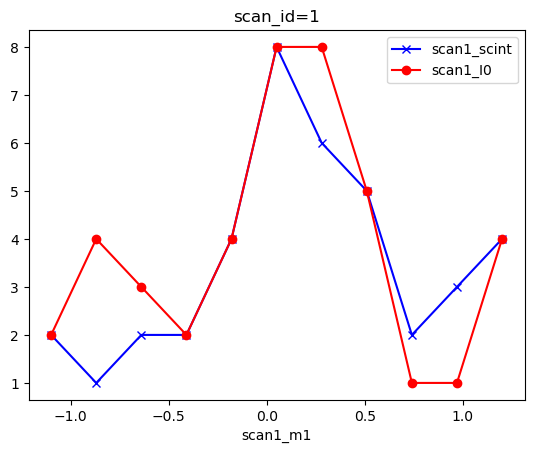

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

x = dataset["scan1_m1"][0]
y1 = dataset["scan1_scint"][0]
y2 = dataset["scan1_I0"][0]

plt.plot(x.values, y1.values, "bx-", label=y1.name)
plt.plot(x.values, y2.values, "ro-", label=y2.name)
plt.xlabel(x.name)
plt.title(f"scan_id={run.metadata['start']['scan_id']}")
plt.legend()